<img src="static/assets/img/logo-pirelli-dsa.png" align="left"/> 
<br>
# Exploratory Data Analysis: Worker Performance Cluster Analysis
***

Data Source: PCS

Factory: Bahia 4.0 

Responsible: Danillo Silva (SMO LatAm) 
***


In [1]:
#Libraries Declaration:
import pandas as pd
import numpy as np
import time
import datetime as dt

from connection import *

import matplotlib.pyplot as plt
import seaborn as sns

import math
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

import gc

%matplotlib inline
plt.style.use('seaborn')

## Dataset Extraction:
***

In [2]:
#Extract Individual Production by Operator from 2nd Phase Building:

day = 30
query = open('query/01_production.sql','r')

df_production = run_queryFS(query.read().format(str(day)))

#Create Pickle For Offline Analysis:
df_production.to_pickle('df_production.pkl')

del query
gc.collect()

93

In [3]:
#Extract Individual Scrap (CAG) by Operator from 2nd Phase Building:

query = open('query/02_waste.sql','r')

df_scrap = run_queryFS(query.read().format(str(day)))

#Create Pickle For Offline Analysis:
df_scrap.to_pickle('df_scrap.pkl')

del query
gc.collect()

93

In [4]:
#Read Pickle for Offline Analysis - In case of Offline Analysis:
df_production = pd.read_pickle('df_production.pkl')
df_scrap = pd.read_pickle('df_scrap.pkl')

## Data Cleaning - Production:
***

In [5]:
#Clear All Records from Production DataFrame equals to '00':
df_production = df_production[df_production['WM_CODE'].astype(str) != '00']

#Clear All Records from Production DataFrame equals to '9999':
df_production = df_production[df_production['WM_CODE'].astype(str) != '9999']

#Exclude Industrializations (Y Codes):
df_production = df_production[df_production['MAT_SAP_CODE'].astype(str).str[0] !="Y"]

In [6]:
#Create Actual Cycle Times Variable:
df_production['ACTUAL_CYCLE_TIME'] = df_production['EVS_END'] - df_production['EVS_START']
df_production['ACTUAL_CYCLE_TIME'] = df_production['ACTUAL_CYCLE_TIME'].apply(lambda x: x / np.timedelta64(1,'s'))

#Create Delta Cycle Times (Theory vs. Actual):
df_production['DELTA_CYCLE_TIME'] = df_production['ACTUAL_CYCLE_TIME'] - df_production['THEORY_CYCLE_TIME']

In [7]:
#Clear All Records w/ ACTUAL_CYCLE_TIMES = 0:
df_production = df_production[df_production['ACTUAL_CYCLE_TIME'] != 0]

#Exclude Outliers from Actual Cycle Times based uppon IQC:
df_production = df_production[((df_production['ACTUAL_CYCLE_TIME'] - df_production['ACTUAL_CYCLE_TIME'].mean()) /
                               df_production['ACTUAL_CYCLE_TIME'].std()).abs() < 3]

#Exclude Outliers from Actual Cycle Times based on Reasonable Premisses (No Actual Cyle Time lower than 25% Against SMS):
df_production = df_production[df_production['ACTUAL_CYCLE_TIME'] > (0.75 * df_production['THEORY_CYCLE_TIME'])]

In [8]:
#Create WORKER_IPCODE Variable:
df_production['WORKER_IPCODE'] = df_production['WM_CODE'] + df_production['MAT_SAP_CODE']

In [9]:
# Validate the Sample Size for WORKER_IPCODE Variable:

#Create a list with all Unique Possibilities From WORKER_IPCODE:
worker_ipcode = list(df_production['WORKER_IPCODE'].unique())

#Iterate across the Production DataFrame all Possibilities and Apply the Normal (Z-Test) Hypothesis Test:
for i in range(len(worker_ipcode)):
    
    values = np.array(df_production[df_production['WORKER_IPCODE'] == worker_ipcode[i]]['ACTUAL_CYCLE_TIME'])
    
    try:
        k2, p = stats.normaltest(values)  
    except:
        p = 999
    
    if p > 0.05:
        df_production = df_production[df_production['WORKER_IPCODE'] != worker_ipcode[i]]
        print(str(worker_ipcode[i]) + ' ' + 'n: {}'.format(len(values)) + ' z-score: {:.5f}'.format(p))

del k2
del p
del i
del worker_ipcode
del values
gc.collect()

25775   SAG8957A0 n: 11 z-score: 0.26545
26982   SAG9094A1 n: 24 z-score: 0.08620
28262   SAG9094A1 n: 1 z-score: 999.00000
01006   SAG9566A0 n: 7 z-score: 999.00000
28546   SAG9566A0 n: 15 z-score: 0.19626
02469   SAG9566A0 n: 14 z-score: 0.28371
28383   SAG8957A0 n: 21 z-score: 0.45431
26763   SAG8957A0 n: 5 z-score: 999.00000
26473   SAG9094A1 n: 6 z-score: 999.00000
26763   SAG9094A1 n: 24 z-score: 0.10276
01006   SAG9562A0 n: 1 z-score: 999.00000
28546   SAG3525A0 n: 6 z-score: 999.00000
60603   SAGA153A0 n: 3 z-score: 999.00000
25578   SAG8957A3 n: 5 z-score: 999.00000
26984   SAG5503A0 n: 11 z-score: 0.23321
26256   SAG9853A1 n: 23 z-score: 0.06915
25822   SAG8277A0 n: 2 z-score: 999.00000
28668   SAG8277A0 n: 1 z-score: 999.00000
00570   SAG5503A0 n: 18 z-score: 0.18737
60557   SAGA331A0 n: 29 z-score: 0.09691
28738   SAG5236A1 n: 16 z-score: 0.17615
26984   SAG5236A1 n: 92 z-score: 0.78268
03266   SAG8277A0 n: 12 z-score: 0.27804
28160   SAG9853A1 n: 7 z-score: 999.00000
28540

0

In [10]:
#Clear Outliers Generated due Data Collection Issues on the ETL Procedures:

#Create a empty DataFrame with the same Structure as the Original Dataset:
df_prod_transf = pd.DataFrame().reindex_like(df_production)
df_prod_transf.dropna(how='all', inplace=True)

#Create a list with all Unique Possibilities From WORKER_IPCODE:
worker_ipcode = list(df_production['WORKER_IPCODE'].unique())

for i in range(len(worker_ipcode)):
       
    values = df_production[df_production['WORKER_IPCODE'] == worker_ipcode[i]]
    values = values[((values['ACTUAL_CYCLE_TIME'] - values['ACTUAL_CYCLE_TIME'].mean()) / values['ACTUAL_CYCLE_TIME'].std()).abs() < 3]
    
    df_prod_transf = df_prod_transf.append(values, ignore_index=True)
    
df_production = df_prod_transf

del df_prod_transf
del i
del worker_ipcode
del values
gc.collect()

0

## Production / Waste DataFrame Figures:
***

In [11]:
#Production DataFrame Main Figures:

print('Production Dataframe\n')
print('Observations(Rows): {}\nVariables(Columns): {}\n'.format(df_production.shape[0],df_production.shape[1]))

print('Unique IP Codes Qty: {}'.format(df_production['MAT_SAP_CODE'].nunique()))
print('Unique Machine Codes Qty: {}\n'.format(df_production['MCH_NUMBER'].nunique()))
print('Unique Operators Qty: {}\n'.format(df_production['WM_CODE'].nunique()))


print('The Main Variables from the Dataframe: \n')
print(df_production.info())
print("")
print(round(df_production.describe(),2))

df_production.head()

Production Dataframe

Observations(Rows): 492936
Variables(Columns): 16

Unique IP Codes Qty: 56
Unique Machine Codes Qty: 19

Unique Operators Qty: 140

The Main Variables from the Dataframe: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492936 entries, 0 to 492935
Data columns (total 16 columns):
WM_CODE               492936 non-null object
TEAM_CODE             492936 non-null object
TEAM_SUBCODE          492936 non-null object
WM_NAME               492936 non-null object
WM_SURNAME            492936 non-null object
WM_EMPLOYMENT_DATE    314381 non-null datetime64[ns]
MCH_NUMBER            492936 non-null object
MT_CODE               492936 non-null object
MAT_SAP_CODE          492936 non-null object
CAL                   492936 non-null object
EVS_START             492936 non-null datetime64[ns]
EVS_END               492936 non-null datetime64[ns]
THEORY_CYCLE_TIME     492936 non-null float64
ACTUAL_CYCLE_TIME     492936 non-null float64
DELTA_CYCLE_TIME      492936 non-null 

,WM_CODE,TEAM_CODE,TEAM_SUBCODE,WM_NAME,WM_SURNAME,WM_EMPLOYMENT_DATE,MCH_NUMBER,MT_CODE,MAT_SAP_CODE,CAL,EVS_START,EVS_END,THEORY_CYCLE_TIME,ACTUAL_CYCLE_TIME,DELTA_CYCLE_TIME,WORKER_IPCODE
0,28136,2D,2D,RODRIGO,BASTOS AMORIM,1753-01-02,V06,CVMI,SAG7905A0,17,2019-02-09 18:10:48,2019-02-09 18:12:06,83.0,78.0,-5.0,28136 SAG7905A0
1,28136,2D,2D,RODRIGO,BASTOS AMORIM,1753-01-02,V06,CVMI,SAG7905A0,17,2019-02-09 18:12:06,2019-02-09 18:13:21,83.0,75.0,-8.0,28136 SAG7905A0
2,28136,2D,2D,RODRIGO,BASTOS AMORIM,1753-01-02,V06,CVMI,SAG7905A0,17,2019-02-09 18:13:21,2019-02-09 18:15:38,83.0,137.0,54.0,28136 SAG7905A0
3,28136,2D,2D,RODRIGO,BASTOS AMORIM,1753-01-02,V06,CVMI,SAG7905A0,17,2019-02-09 18:15:38,2019-02-09 18:16:56,83.0,78.0,-5.0,28136 SAG7905A0
4,28136,2D,2D,RODRIGO,BASTOS AMORIM,1753-01-02,V06,CVMI,SAG7905A0,17,2019-02-09 18:16:56,2019-02-09 18:18:10,83.0,74.0,-9.0,28136 SAG7905A0


In [12]:
#Scrap DataFrame Main Figures:

print('Scrap Dataframe\n')
print('Observations(Rows): {}\nVariables(Columns): {}\n'.format(df_scrap.shape[0],df_scrap.shape[1]))

print('Unique IP Codes Qty: {}'.format(df_scrap['MAT_SAP_CODE'].nunique()))
print('Unique Machine Codes Qty: {}\n'.format(df_scrap['MCH_NUMBER'].nunique()))
print('Unique Operators Qty: {}\n'.format(df_scrap['WM_CODE'].nunique()))


print('The Main Variables from the Dataframe: \n')
df_scrap.info()
print("")
print(round(df_scrap.describe(),2))

df_scrap.head()

Scrap Dataframe

Observations(Rows): 1279
Variables(Columns): 4

Unique IP Codes Qty: 78
Unique Machine Codes Qty: 20

Unique Operators Qty: 127

The Main Variables from the Dataframe: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1279 entries, 0 to 1278
Data columns (total 4 columns):
WM_CODE         1279 non-null object
MCH_NUMBER      1279 non-null object
MAT_SAP_CODE    1279 non-null object
WST_QUANTITY    1279 non-null float64
dtypes: float64(1), object(3)
memory usage: 40.0+ KB

       WST_QUANTITY
count       1279.00
mean           1.14
std            1.49
min            1.00
25%            1.00
50%            1.00
75%            1.00
max           25.00


,WM_CODE,MCH_NUMBER,MAT_SAP_CODE,WST_QUANTITY
0,26041,TL1,SAGA152A0,1.0
1,26041,TL1,SAGA152A0,1.0
2,26041,TL1,SAGA152A0,1.0
3,26041,TL1,SAGA152A0,1.0
4,26041,TL1,SAGA152A0,1.0


## Grouped DataFrame Setup:
<br>
DataFrame that contains the Grouped Production, Waste and Performance (Delta) by each Operator, splited by:
* Machine
* Material

***

In [13]:
#Create Grouped DataFrame - Overall Performance by Operator:

df_group_worker = df_production.groupby(by=['WM_CODE','WM_NAME','MT_CODE','MCH_NUMBER','MAT_SAP_CODE','CAL'], as_index=False).agg(
    {'EVS_START':'count', 'DELTA_CYCLE_TIME':'sum'})

df_group_worker.rename(columns={'EVS_START':'PRODUCTION'}, inplace=True)

df_group_worker.head()

,WM_CODE,WM_NAME,MT_CODE,MCH_NUMBER,MAT_SAP_CODE,CAL,PRODUCTION,DELTA_CYCLE_TIME
0,00003,EDVAN,CVMI,V01,SAG7725A0,17,81,223.0
1,00003,EDVAN,CVMI,V03,SAG8277A0,17,15,209.0
2,00003,EDVAN,CVMI,V04,SAG7582A0,17,47,586.0
3,00003,EDVAN,CVMI,V04,SAG7700A1,17,3195,6897.0
4,00003,EDVAN,CVMI,V04,SAG8352A0,17,458,-1708.0


In [14]:
#Create Grouped DataFrame - Overall Scrap by Operator:

df_group_scrap = df_scrap.groupby(by=['WM_CODE','MCH_NUMBER','MAT_SAP_CODE'], as_index=False).agg({'WST_QUANTITY':'sum'})
df_group_scrap.head()

,WM_CODE,MCH_NUMBER,MAT_SAP_CODE,WST_QUANTITY
0,00,V04,SAG7994A0,105.0
1,00,V04,SAG8896A1,15.0
2,00,V07,SAG8896A1,65.0
3,00003,V04,SAG7700A1,4.0
4,00003,V04,SAG8352A0,2.0


In [15]:
#Merge Scrap DataFrame into Performance DataFrame:

df_group_worker = pd.merge(left= df_group_worker, right= df_group_scrap, left_on=['WM_CODE','MCH_NUMBER','MAT_SAP_CODE'], 
                          right_on=['WM_CODE','MCH_NUMBER','MAT_SAP_CODE'], how='left')

df_group_worker.fillna(value=0, inplace=True)

del df_group_scrap
gc.collect()

df_group_worker.head()

,WM_CODE,WM_NAME,MT_CODE,MCH_NUMBER,MAT_SAP_CODE,CAL,PRODUCTION,DELTA_CYCLE_TIME,WST_QUANTITY
0,00003,EDVAN,CVMI,V01,SAG7725A0,17,81,223.0,0.0
1,00003,EDVAN,CVMI,V03,SAG8277A0,17,15,209.0,0.0
2,00003,EDVAN,CVMI,V04,SAG7582A0,17,47,586.0,0.0
3,00003,EDVAN,CVMI,V04,SAG7700A1,17,3195,6897.0,4.0
4,00003,EDVAN,CVMI,V04,SAG8352A0,17,458,-1708.0,2.0


## Cluster Analysis I: Overall Cluster VMI
<br>
Define Operator Cluster Using Cumulated Totals: Production, Performance
***

In [16]:
#Filter for CVMI:
df_group_VMI = df_group_worker[df_group_worker['MT_CODE']=='CVMI']
df_group_VMI = df_group_VMI.groupby(by=['WM_CODE','WM_NAME'], as_index=False).agg({'PRODUCTION':'sum','DELTA_CYCLE_TIME':'sum','WST_QUANTITY':'sum'})

df_group_VMI.head()

,WM_CODE,WM_NAME,PRODUCTION,DELTA_CYCLE_TIME,WST_QUANTITY
0,00003,EDVAN,6092,13316.0,12.0
1,01006,CARLOS ALBERTO,2622,31302.0,15.0
2,02469,MATHEUS,3849,17582.0,12.0
3,02481,FABIO,2684,11121.0,27.0
4,02485,GERLAN,1620,11811.0,11.0


### Hierarchical Clustering: Dendrogram
***

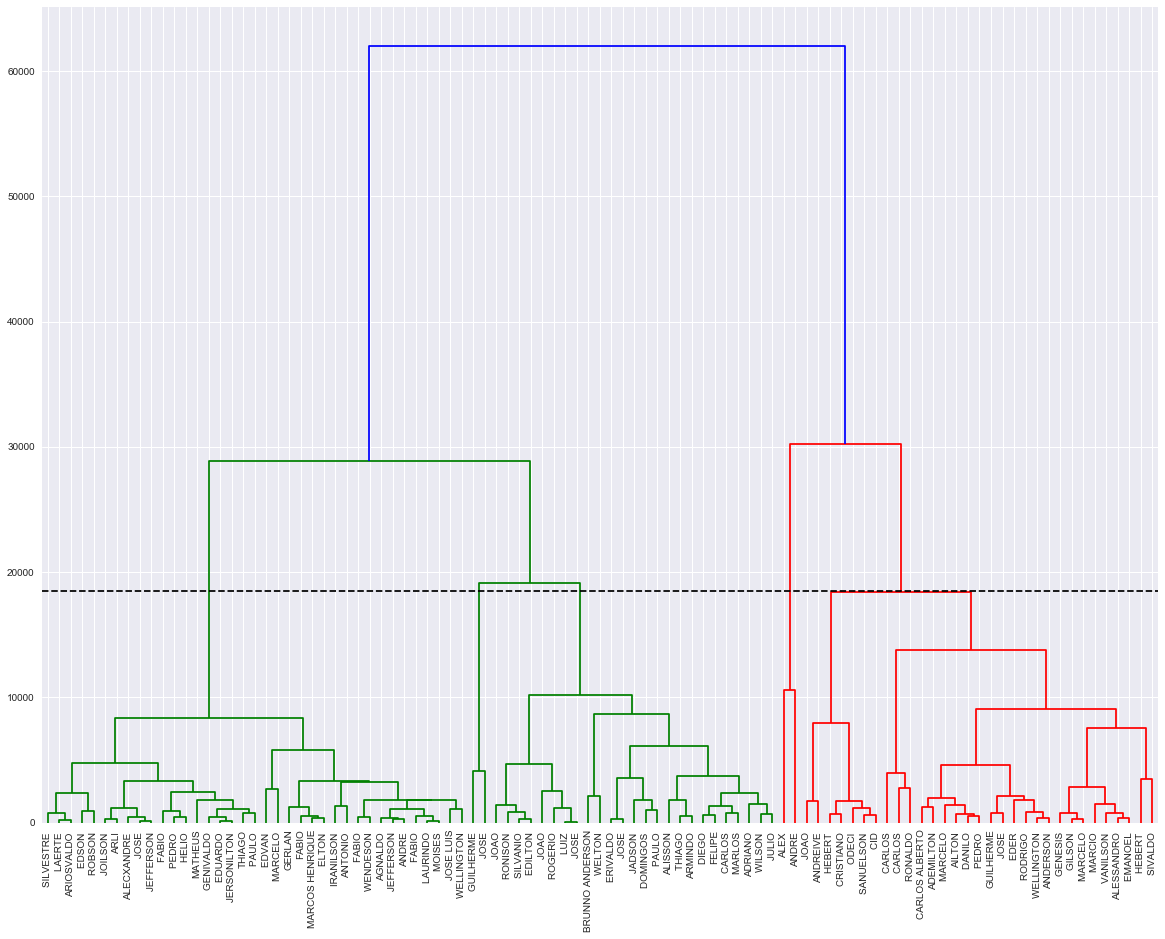

In [25]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster

name = list(df_group_VMI['WM_NAME'])

mergings = linkage(df_group_VMI.iloc[:,2:4], method='complete')

_= plt.figure(figsize=(20,15))
_= dendrogram(mergings,labels=name, leaf_rotation=90, leaf_font_size=10)

_= plt.hlines(18500,xmin=0,xmax=2000, linestyles='dashed')

### Cluster w/ K-Means:
***

In [18]:
#Machine Learning Methods:
from sklearn.cluster import KMeans

#Preprocessing Libraries:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

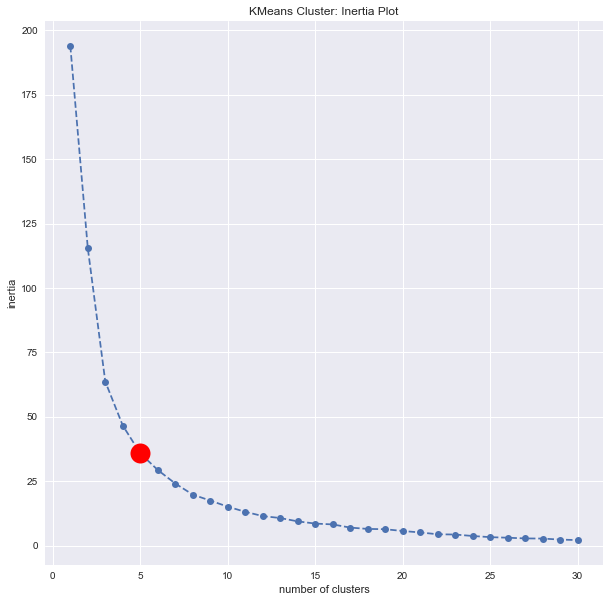

In [19]:
#Calculate Inertia across Multiple Cluster Sizes:

steps = np.arange(1,31)
inertia =[]

for i in steps:
    
    #Create Scaler Preprocessor
    scaler = StandardScaler()
    
    #Create KMeans Instance
    kmeans = KMeans(n_clusters=i, random_state=42)
    
    #Create Pipeline
    pipeline = make_pipeline(scaler, kmeans)
    pipeline.fit(df_group_VMI.iloc[:,2:4])
    
    inertia.append(pipeline.named_steps['kmeans'].inertia_)

_= plt.figure(figsize=(10,10))

_= plt.plot(steps, inertia, marker= 'o', linestyle= 'dashed')

_= plt.plot(5, inertia[4], marker='o', color='red', markersize=20)

_= plt.xlabel('number of clusters')
_= plt.ylabel('inertia')

_= plt.title('KMeans Cluster: Inertia Plot')



In [20]:
#Create Scaler Preprocessor
scaler = StandardScaler()

#Create KMeans Instance
kmeans = KMeans(n_clusters=5, random_state=42)

#Create Pipeline
pipeline = make_pipeline(scaler, kmeans)

#Run Model:

pipeline.fit(df_group_VMI.iloc[:,2:4])
labels = pipeline.predict(df_group_VMI.iloc[:,2:4])

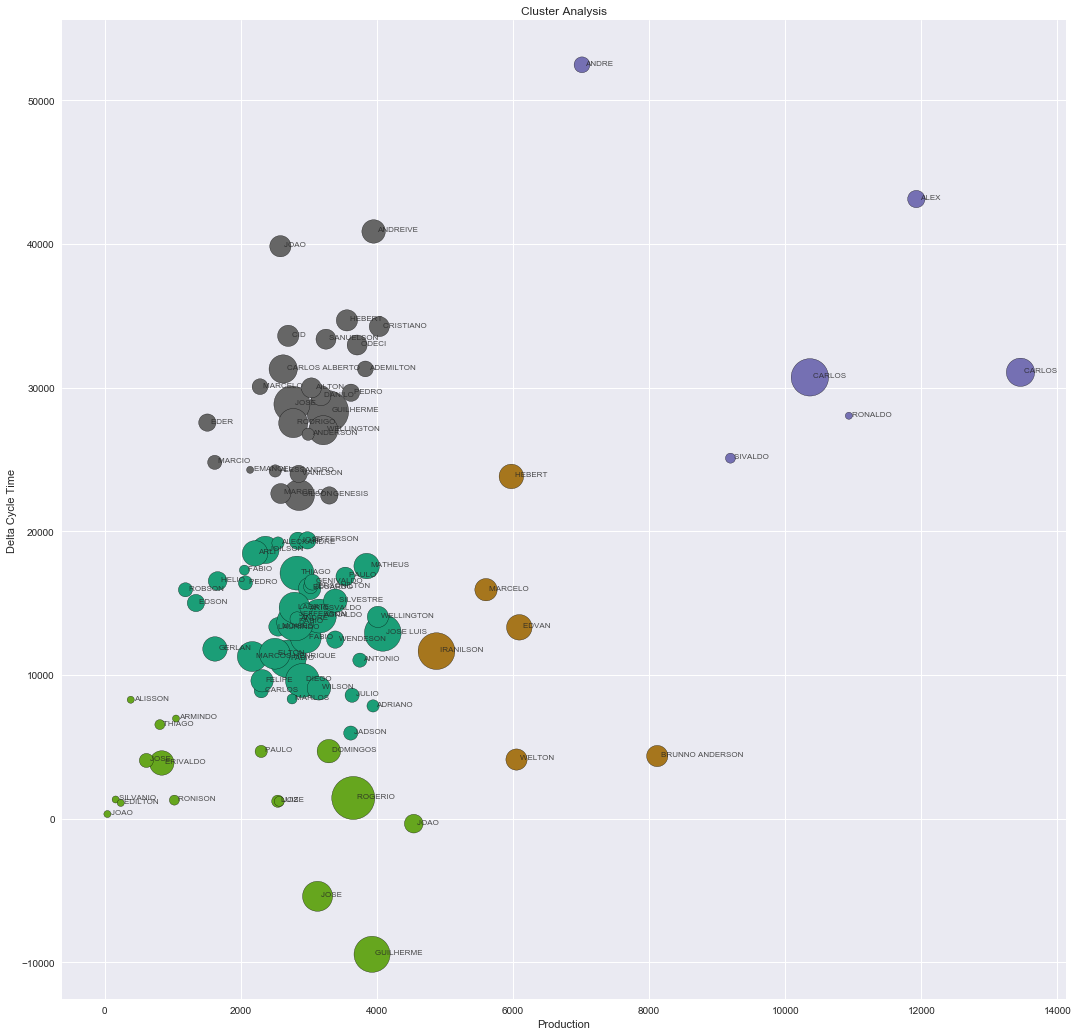

In [21]:
#Plot Results - Scatter Plot:

_= plt.figure(figsize=(18,18))


_= plt.scatter(df_group_VMI['PRODUCTION'],df_group_VMI['DELTA_CYCLE_TIME'], c=labels,
               cmap='Dark2', edgecolors='black', s=(df_group_VMI['WST_QUANTITY']+1)*50)

_= plt.title('Cluster Analysis')
_= plt.xlabel('Production')
_= plt.ylabel('Delta Cycle Time')

for i, txt in enumerate(df_group_VMI['WM_NAME']):
    plt.annotate(txt, (df_group_VMI.PRODUCTION[i]+50,df_group_VMI.DELTA_CYCLE_TIME[i]), alpha=0.8, size=8)


### t-SNE Cluster:
<br>
t-SNE = “t-distributed stochastic neighbor embedding”
<br>
Maps samples to 2D space approximately preserves nearness of samples. Useful for datasets inspection
***

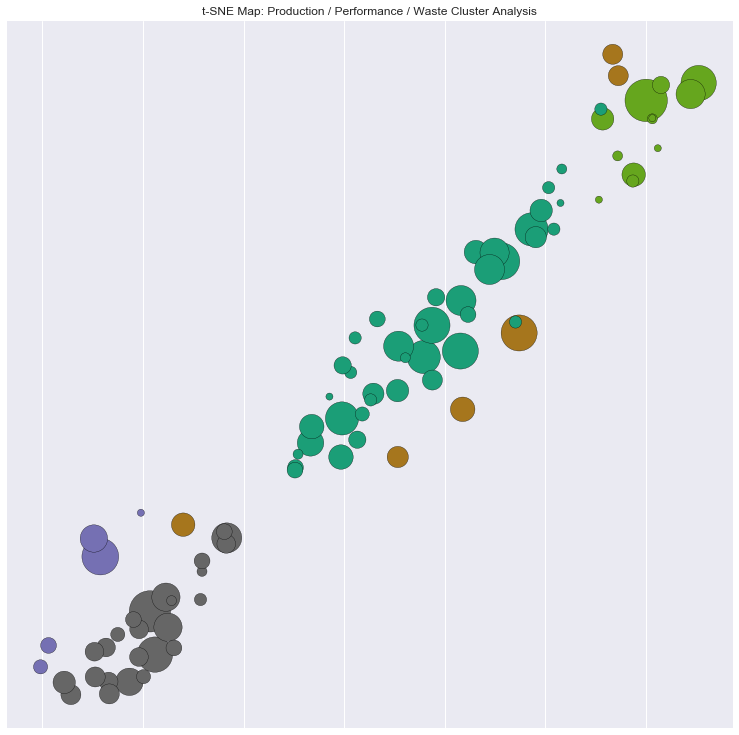

In [22]:
from sklearn.manifold import TSNE

model = TSNE(learning_rate=150)
transformed = model.fit_transform(df_group_VMI.iloc[:,2:5])

xs= transformed[:,0]
ys= transformed[:,1]

_= plt.figure(figsize=(13,13))

_= plt.scatter(xs, ys, c=labels, cmap='Dark2', s=df_group_VMI['WST_QUANTITY']*50, edgecolors='black')

_= plt.title('t-SNE Map: Production / Performance / Waste Cluster Analysis')

ax= plt.axes()
ax.yaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_formatter(plt.NullFormatter())